<a href="https://colab.research.google.com/github/tua2542/Practical-Exam-SO/blob/main/2_The_Tale_of_Two_Wat_SO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem 2: The Tale of Two Wat
## Author

Sakdipat Ontoum 

Chulalongkorn AI Academy candidator

sakdipat.2542@mail.kmutt.ac.th

https://tua2542.github.io/sakdipat-portfolio/


Copyright 2022 Sakdipat Ontoum

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Introduction
Wat Prakaew and Wat Po are two of Thailand's most visited temples. Thousands of tourists visit Thailand each year to marvel at the temples' architectural marvels. Unfortunately, many temple visitors are sometimes perplexed as to whether their holiday photos were shot at Wat Prakaew or Wat Po. To salvage what is left of their trip, a machine learning specialist is approached and charged with developing a Machine Learning model that can distinguish between photos taken at Wat Prakaew and Wat Po.

![Fig.1. Sample image of Wat Prakaew](https://www.thailandtravelhub.com/wp-content/uploads/2016/11/wat_phra_kaew_temple.jpg)

Fig.1. Sample image of Wat Prakaew

![Fig.2. Sample image of Wat Po](https://d13jio720g7qcs.cloudfront.net/images/destinations/848_477/5dcb8e684efc0.jpg)

Fig.2. Sample image of Wat Po


### Objective
The aim is to create a model that can predict whether a photograph was shot at Wat Prakraew or Wat Po - a binary classification challenge. There is a chance that no temples appear in the images, however it is assumed that no such images exist in the samples.

### Approach
This machine learning project is divided into two parts which are Model development and data mining. Model deployment and operationalization will not be discussed because this model will not be put to production until later.

The training dataset will first be extracted from the internet using Google and Bing image search API, and Selenium. Each class should require around 228 samples.

Second, because the training dataset has a large sample size, a deep convolutional neural network will be used to tackle this task. Convolutional Neural Networks are more adapted to dealing with large dimensionality picture data, but they require specialized hardware to process the information, such as a Graphical Processing Unit (GPU). Traditional computer vision procedures, such as SIFT feature extraction and bag of SIFTs classification, may be more appropriate in the absence of specialist hardware and a large training dataset.

Complex Deep Neural Networks often need considerable training with millions of training examples. With limited resources and time, the transfer learning technique will be combined with a cutting-edge CNN model, notably Xception model. The Xception model is simple to use and resistant to a wide range of modifications such as scaling, translation, and rotation. Color standardization and data augmentation are common image preprocessing techniques that are not required.

Moreover, this machine learning project is keep track of my process across project through WanDB. For example, hyperparameter, and system metrics with live model.

### Dataset
The training dataset will be collected using the Google Image Search and Bing Image Search APIs, and also Selenium.

### Performance Measure
The data given by the reviewing committee will be utilized to validate the model's performance. Because there are no consequences for False Positive and False Negative, the model will be improved and tested for precision. Nonetheless, the ROC Curve and F1 score will be computed for reference.




# 1. Configurations

## 1.1 Install and Imports Library

All the install Library go here.

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 4.9 MB/s 
     |████████████████████████████████| 145 kB 22.3 MB/s 
     |████████████████████████████████| 181 kB 55.7 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0482f327d41e7ab70e555d297aec1d6a2e53013a099e25fab179fa31b117f310
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


All the imports go here.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
from tqdm import tqdm
from PIL import Image
import pandas as pd
import zipfile
import cv2
import tensorflow as tf
import seaborn as sns 
from glob import glob
import wandb


from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, log_loss, precision_recall_fscore_support


import keras
from keras import Model
from keras import optimizers
from keras import layers
from wandb.keras import WandbCallback
from keras.utils import np_utils
from sklearn import preprocessing
from keras.optimizers import adam_v2
from keras.optimizers import gradient_descent_v2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Activation,ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.applications.xception import Xception



## 1.2 Mount Google Drive and Wandb Authenication

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
wandb.login()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## 1.3 Dataset Importation

The dataset will be imported from my Google Share Drive as Zip file. There is consist of Training and Test image dataset. 
Then, its extracted those for using across the project.

In [ ]:
wat_dataset = "/content/drive/Shareddrives/Chula-UTC-Pract-Exam/Problem 2/dataset.zip"

In [ ]:
check_dir = os.path.exists('/content/dataset')
if (check_dir == True):
  print("Found wat dataset directory")
else:
  with zipfile.ZipFile(wat_dataset, 'r') as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
      zip_ref.extract(member=file)

100%|██████████| 471/471 [00:01<00:00, 293.82it/s]


## 1.4 Global Settings

There variabls will be used across the project.

In [ ]:
#Random seeds
SEED = 1152022
np.random.seed(SEED)

#Image Settings
IMAGE_RESIZE = (299,299)  # Image size. Process on the by data generator. 
IMAGE_INPUT_SIZE = (299,299,3) #Image Input size to the neural network

#Training Settings
BATCH_SIZE = 32
EPOCH = 10

#Directories
# NOTE: The labels are determined by subfolders. PNG or JPEG images only.
TRAIN_DIR = '/content/dataset/train/'
TEST_DIR =  '/content/dataset/test/'

#Index of the class label represents numerical representation
CLASS = { 'Wat Po': 0, 'Wat Prakaew': 1 }

INV_CLASS = {CLASS[j]:j for j in CLASS}

NUM_CLASSES = 2

#Checkpoints and save files

#Saving every epochs that improve val accuracy
# MODEL_WEIGHT_FILE="/content/drive/Shareddrives/Chula-UTC-Pract-Exam/Problem 2/wat-classification-inception-v3.hdf5" 
MODEL_WEIGHT_FILE="/content/drive/Shareddrives/Chula-UTC-Pract-Exam/Problem 2/wat-classification-Xception.hdf5" 


#wandb
wandb.init(project="My-Tale-of-Two-Wat", entity="kratua2542")

wandb.config = {
  "epochs": EPOCH,
  "batch_size": BATCH_SIZE
}


wandb: Currently logged in as: kratua2542. Use `wandb login --relogin` to force relogin


## 1.5 Execution Environment Information
Obtaining system RAM and a graphics card. This might have an impact on training decisions. A lack of accessible RAM necessitates the usage of data streaming tools such as data generators, and it also has an impact on image batch size.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9

print("There are {:.1f} GB of RAM available".format(ram_gb))

There are 13.6 GB of RAM available


In [ ]:
!nvidia-smi

Sat May 14 04:06:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 2. Data Preprocessing

Because the Xception model is user-friendly and typically resilient against all types of perturbations, data pretreatment is necessary.

## 2.1 Image Resizing
By default, resize the image to fit the input layer within 229 X 229.

In [ ]:
def preprop_img(image_path, verbose=0):
    if verbose:
        print(image_path)
    img=cv2.imread(image_path)
    img=cv2.resize(img, IMAGE_RESIZE)
    return img

Reading the train image file and converting them to array



In [ ]:
def ImageConverter(path):
  image = []
  labels = []
  files = glob(path)
  BASE = path
  for i in tqdm(os.listdir(BASE), total=len(CLASS)):
    for j in os.listdir(os.path.join(BASE, i)):
      image.append(preprop_img(os.path.join(BASE, i, j)))
      files.append(path)
      labels.append(CLASS[i])
  return np.array(image), np.array(labels)

In [ ]:
train_image, train_label = ImageConverter(TRAIN_DIR)

100%|██████████| 2/2 [00:04<00:00,  2.34s/it]


Review the dimensions of the data

In [ ]:
print ("Shape of the Training Input: {}".format(train_image.shape))
print ("Shape of the Training Target: {}".format(train_label.shape))

Shape of the Training Input: (456, 299, 299, 3)
Shape of the Training Target: (456,)


In [ ]:
def label_Cat(label):
  label_cat = np_utils.to_categorical(label,len(CLASS))
  return label_cat

In [ ]:
def visulizeWat(image,label):
  plt.figure(figsize=(12,12))
  for i in range(2):
    plt.subplot(2,2,i+1)
    
    index = np.where(label==i)[0][1]
    plt.imshow(image[index])
    plt.title(INV_CLASS[np.argmax(label_Cat(label[index]))])
    plt.xticks([]), plt.yticks([])
  plt.tight_layout()
  plt.show()

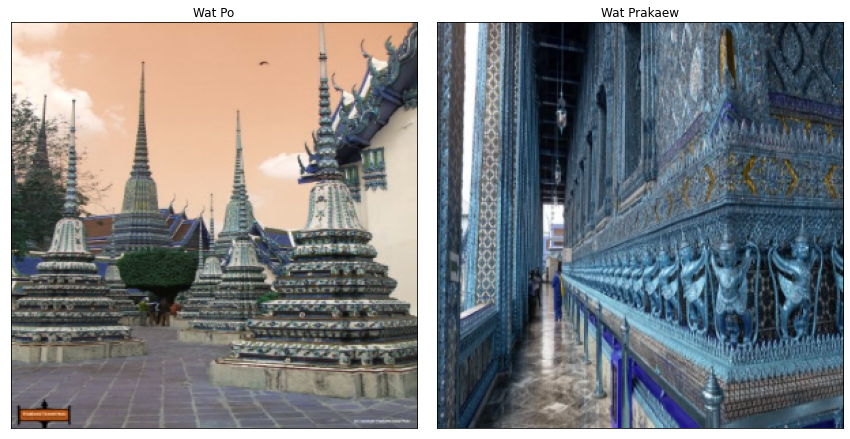

In [ ]:
wat_train_image = visulizeWat(train_image,train_label)

## 3.x Cleaning

To cleaning image data by removing some background from original. There used the gaussian blur to remove noise and then convert RGB image  to HSV image which is the color system between of Hue, Saturation, and Value.

In [ ]:
def cleanImage(image):
  clearImages = []
  examples = []; getEx = True
  plt.figure(figsize=(10,9))
  
  for img in image:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
     
    clearImages.append(hsvImg)  # Append image without background
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.xticks([]), plt.yticks([]), plt.title("Original Image")
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.xticks([]), plt.yticks([]), plt.title("Blur Image")
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.xticks([]), plt.yticks([]), plt.title("HSV Image")
        getEx = False

  plt.tight_layout()
  return clearImages

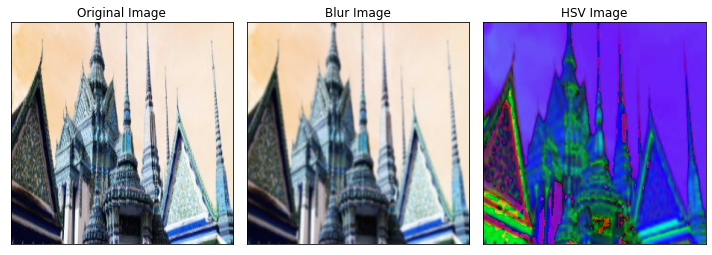

In [ ]:
#clean train image
clear_train_image = cleanImage(train_image)

## 2.x Normalization and Catogory Encoding

The Xception Network anticipates that the picture pixel data will be between 0 and 1. Unfortunately, a picture pixel is often represented as a byte with a value between 0 and 255. As a result, the picture input must be normalized by dividing it by 255.0. The classification layer will be sigmoid with two classes. This necessitates that the intended output be one-hot encoded.

In [ ]:
clearTrainImg = np.asarray(clear_train_image)
clearTrainImg = clearTrainImg / 255

In [ ]:
# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(train_label)
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(train_label)

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

Classes: [0 1]
Number of classes: 2


In [ ]:
X_train, X_valid, y_train, y_valid =  train_test_split(clearTrainImg, clearTrainLabel, shuffle=True,test_size=0.2,stratify = clearTrainLabel)
print ("Shape of the Training Input: {}".format(X_train.shape))
print ("Shape of the Training Target: {}".format(y_train.shape))

print ("Shape of the Validation Input: {}".format(X_valid.shape))
print ("Shape of the Validation Target: {}".format(y_valid.shape))

Shape of the Training Input: (364, 299, 299, 3)
Shape of the Training Target: (364, 2)
Shape of the Validation Input: (92, 299, 299, 3)
Shape of the Validation Target: (92, 2)


# 3. Model Creation

## 3.1 Xception

The Xception network with ImageNet pre-trained weights is used to initialize the model. For binary classification, the classification layer is replaced with two sigmoid functions.


In [ ]:
# Building Models

def XceptionNet():
    #https://keras.io/applications/#inceptionv3
    #Use Inception 3 without the last layer.
    #Replace last layer with two class softmax for binary classification
    sgd = gradient_descent_v2.SGD(lr=0.01, momentum=0.9,nesterov=False)
    model = keras.applications.xception.Xception(include_top=False,
                                                        weights='imagenet',  #Use pre-train weight from ImageNet for transfer learning
                                                        input_tensor=Input(shape=IMAGE_INPUT_SIZE),
                                                        input_shape=None,
                                                        pooling='avg',
                                                        classes=NUM_CLASSES)
    final = Model(model.input,Dense(NUM_CLASSES, activation='sigmoid')(model.output))
    final.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])    
    return final

In [ ]:
def generateTrainingPlots(history):
    plt.style.use('ggplot')
    accuracy_plot = plt.figure(figsize=(15,10))
    for k in ['val_accuracy', 'accuracy']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylim((0,1.2))
    plt.legend(['acc(valid)', 'acc(train)'], loc='upper left')
    plt.grid(True)
    plt.show()
    loss_plot = plt.figure(figsize=(15,10))
    for k in ['loss', 'val_loss']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Loss')
    plt.ylabel('Error (Log Loss)')
    plt.xlabel('Epoch Number')
    plt.grid(True)
    plt.legend(['error(train)', 'error(valid)'], loc='upper left')
    plt.show()

# 3.2 Overview of the machine learning model

In [ ]:
XceptionNet().summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


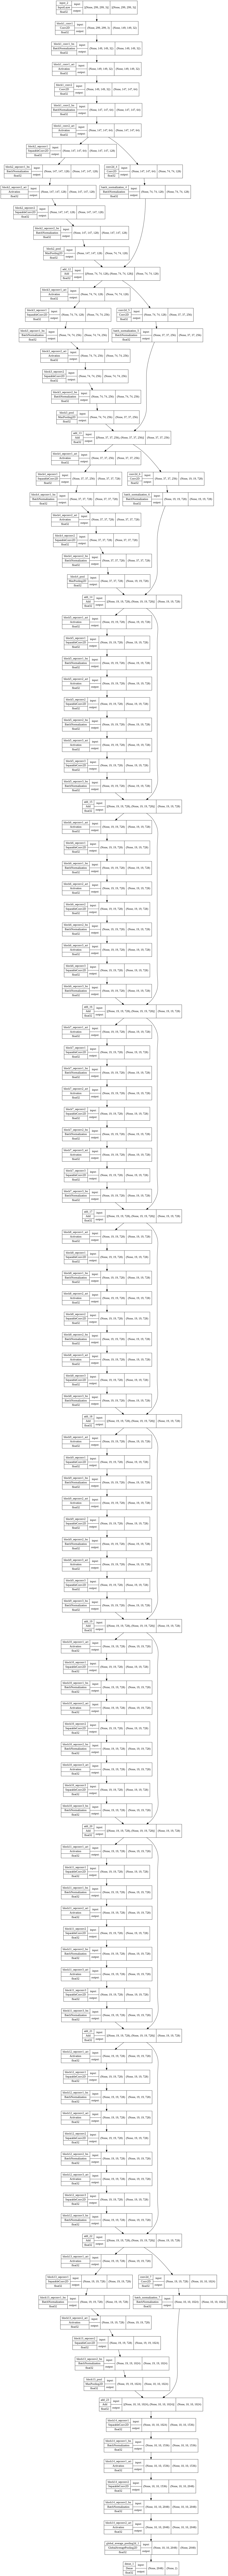

In [ ]:
tf.keras.utils.plot_model(
    XceptionNet(),
    to_file="/content/drive/Shareddrives/Chula-UTC-Pract-Exam/Problem 2/my_model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    layer_range=None,
    
)

# 4. Training

Because of the long training period, only 10 epochs will be assessed.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
12/12 [==============================] - 35s 1s/step - loss: 0.7000 - accuracy: 0.4753 - val_loss: 0.6684 - val_accuracy: 0.5870 - _timestamp: 1652501268.0000 - _runtime: 60.0000
Epoch 2/10
12/12 [==============================] - 13s 1s/step - loss: 0.5795 - accuracy: 0.8516 - val_loss: 0.6354 - val_accuracy: 0.6413 - _timestamp: 1652501282.0000 - _runtime: 74.0000
Epoch 3/10
12/12 [==============================] - 13s 1s/step - loss: 0.4405 - accuracy: 0.9093 - val_loss: 0.6410 - val_accuracy: 0.6196 - _timestamp: 1652501295.0000 - _runtime: 87.0000
Epoch 4/10
12/12 [==============================] - 14s 1s/step - loss: 0.2703 - accuracy: 0.9615 - val_loss: 0.5591 - val_accuracy: 0.6848 - _timestamp: 1652501308.0000 - _runtime: 100.0000
Epoch 5/10
12/12 [==============================] - 13s 1s/step - loss: 0.1398 - accuracy: 0.9945 - val_loss: 0.5533 - val_accuracy: 0.6957 - _timestamp: 1652501322.0000 - _runtime: 114.0000
Epoch 6/10
12/12 [==============================

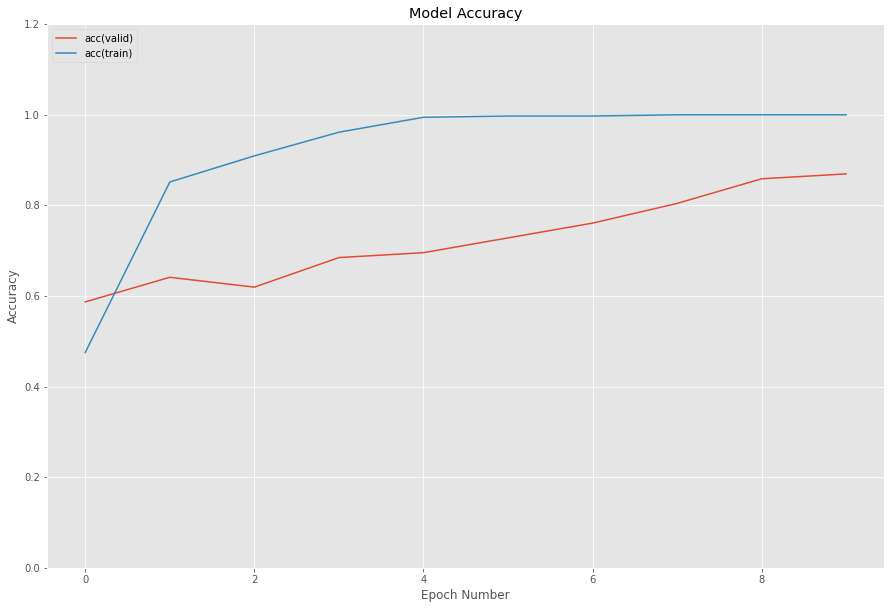

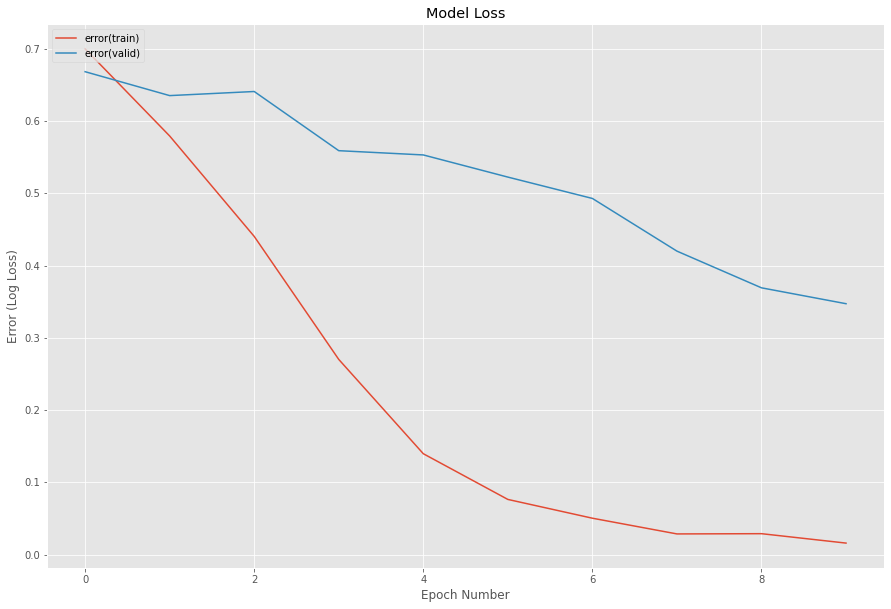

In [ ]:
run_this = True #Prevent accidental execution

if run_this:
  model = XceptionNet()

  #Early stopping by only saving the weight with the best validation accuracy
  checkpoint = ModelCheckpoint(MODEL_WEIGHT_FILE, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint, WandbCallback()]
  
  #Training
  history = model.fit(x=X_train,y=y_train,
                      validation_data=(X_valid,y_valid),
                      batch_size=BATCH_SIZE,
                      epochs = EPOCH,
                      callbacks = callbacks_list)

  #Generate training graphs
  generateTrainingPlots(history.history) 

In [ ]:
run_this = True

if run_this:
  export_path = model.save(MODEL_WEIGHT_FILE)

# 5. Evaluation
The model is compared to the test samples. Unfortunately, only 8 test samples are available. A wide range of scores is to be expected.

In [ ]:
'''
    For the given path, get the List of all files in the directory tree 
'''
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [ ]:
X_test, y_test = ImageConverter(TEST_DIR)
print ("Shape of the Evaluation Input: {}".format(X_test.shape))
print ("Shape of the Evaluation Target: {}".format(y_test.shape))

100%|██████████| 2/2 [00:00<00:00, 20.46it/s]

Shape of the Evaluation Input: (8, 299, 299, 3)
Shape of the Evaluation Target: (8,)


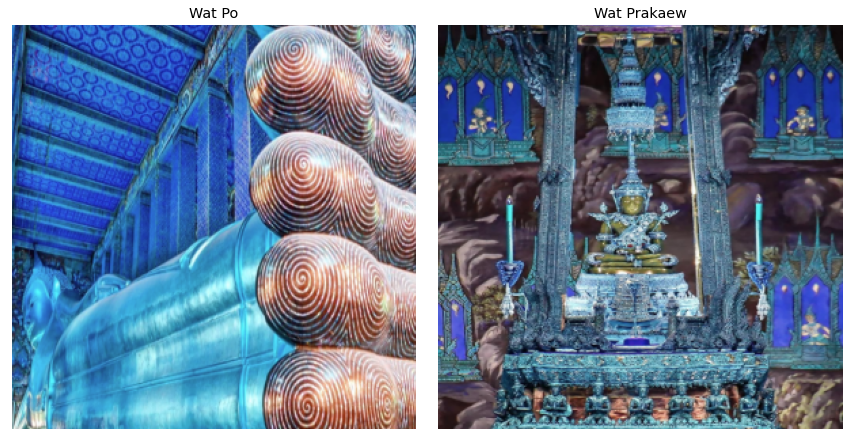

In [ ]:
wat_test_image = visulizeWat(X_test,y_test)

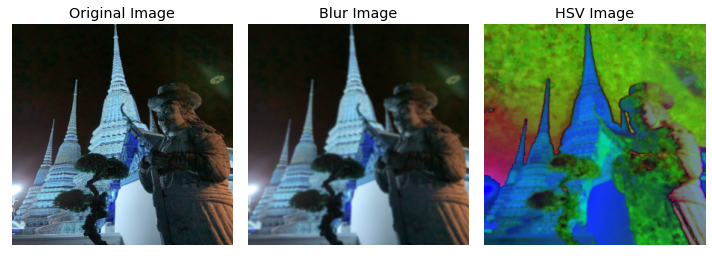

In [ ]:
#clean test image
clear_test_image = cleanImage(X_test)

In [ ]:
#Normalizing the test data
X_test = np.asarray(clear_test_image)
X_test = X_test / 255

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
predict_result = np.argmax(y_pred, axis=1)

In [ ]:
testId = []
for i in getListOfFiles(TEST_DIR):
    testId.append(i.split('/')[-1]) 

In [ ]:
predStr=[]
for i in predict_result:
    predStr.append(INV_CLASS[i])

In [ ]:
res = {'file': testId, 'Temple': predStr}
res = pd.DataFrame(res)
res

file       Temple
0       po4.png       Wat Po
1       po1.png       Wat Po
2       po2.png  Wat Prakaew
3       po3.png       Wat Po
4  prakeaw3.png  Wat Prakaew
5  prakeaw4.png  Wat Prakaew
6  prakeaw1.png  Wat Prakaew
7  prakeaw2.png  Wat Prakaew

In [ ]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1., annot=True)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_ROC(y, y_pred):
    fpr, tpr, threshold = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def classifyReport(y, y_pred):

  print('Accuracy Score :', accuracy_score(y, y_pred))
  print('Report :')
  print(classification_report(y, y_pred))

  score_2 = f1_score(y, y_pred, average='macro')
  print('F-measure: {:.4f}'.format(score_2))


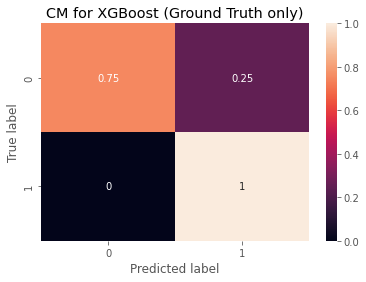

---------------------------------------------------------


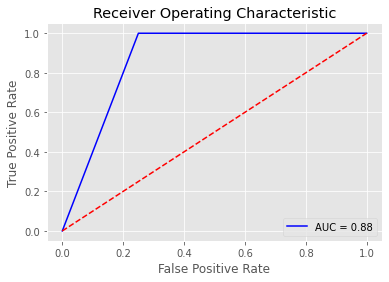

---------------------------------------------------------
Accuracy Score : 0.875
Report :
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.80      1.00      0.89         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8

F-measure: 0.8730


In [ ]:
# Display CM from one of tests
cm = confusion_matrix(y_test, predict_result)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, title="CM for XGBoost (Ground Truth only)")    
plt.show()
print("---------------------------------------------------------")

# Plot ROC
plot_ROC(y_test, predict_result)
print("---------------------------------------------------------")

# Summarize Scores
classifyReport(y_test, predict_result)

# 5. Analysis 
The model performs admirably, with only one incorrect label on the eight photos provided. I feel this model is ready for production deployment based on its 87 percent validation performance over hundreds of photos in the validation set.

# 6. Conclusion
In this challenge, I created a machine learning model that can classify photographs of Wat Pho and Wat Phra Kaew in the wild. Bing and Google Image Search APIs, and also Selenium, are used to mine the training data. Due to restricted resources, I used transfer learning using an Xception Convolutional Neural Network that was pre-trained with ImageNet competition weights. In the validation set, the model has an accuracy of more than 86 percent, and it properly classifies 7 of the 8 test photos provided by the committee.

#Appredix

Image Dataset that retrived from Bing and Google Image Search APIs, and also Selenium

*   [Wat Prakaew and Wat Po Dataset as zip file](https://drive.google.com/file/d/15BQQ7zzLheSYandPsWUKZvqh5IXnj5h3/view?usp=sharing)

*   [Wat Prakaew and Wat Po Dataset as google drive folder](https://drive.google.com/drive/folders/1MBKlKO1rsmO-YohB5is_rcWzs5FACHkF?usp=sharing)

Saved Model from Xception model

*  [Xception Model as hdlf5 file](https://drive.google.com/file/d/1MamoT5ouTUr3jcvuIhqb7OP0xS2M3xPz/view?usp=sharing)






